In [81]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt

%matplotlib inline

# Task 0
Data extraction: get the data from 3 tables & combine it into single `.csv` file.
After that read this file using pandas to create Dataframe.
So it will be all joined data in 1 dataframe. Quick check - should be 74818 rows in it.

In [82]:
conn = sqlite3.connect("../db.sqlite3")
cursor = conn.cursor()
query = """
SELECT 
    restaurant_product.name,
    restaurant_orderitem.quantity,
    restaurant_product.price,
    restaurant_order.datetime
FROM 
    restaurant_orderitem
JOIN 
    restaurant_product
ON 
    restaurant_orderitem.product_id = restaurant_product.id
JOIN 
    restaurant_order
ON 
    restaurant_orderitem.order_id = restaurant_order.id
"""
df = pd.read_sql_query(query, conn)
conn.close()
df.to_csv("combined_data.csv", index=False)
df_check = pd.read_csv("combined_data.csv")


In [83]:
df_check.head(5)

,name,quantity,price,datetime
0,Plain Papadum,2,0.80,2019-08-03 20:25:00
1,King Prawn Balti,1,12.95,2019-08-03 20:25:00
2,Garlic Naan,1,2.95,2019-08-03 20:25:00
3,Mushroom Rice,1,3.95,2019-08-03 20:25:00
4,Paneer Tikka Masala,1,8.95,2019-08-03 20:25:00


In [84]:
df_check.describe()

,quantity,price
count,74818.000000,74818.000000
mean,1.243564,5.267512
std,0.798207,3.325707
min,1.000000,0.500000
25%,1.000000,2.950000
50%,1.000000,3.950000
75%,1.000000,8.950000
max,51.000000,17.950000


# Task 1
Get Top 10 most popular products in restaurant sold by Quantity.
Count how many times each product was sold and create a pie chart with percentage of popularity (by quantity) for top 10 of them.

Example:

![pie chart](../demo/pie.png)

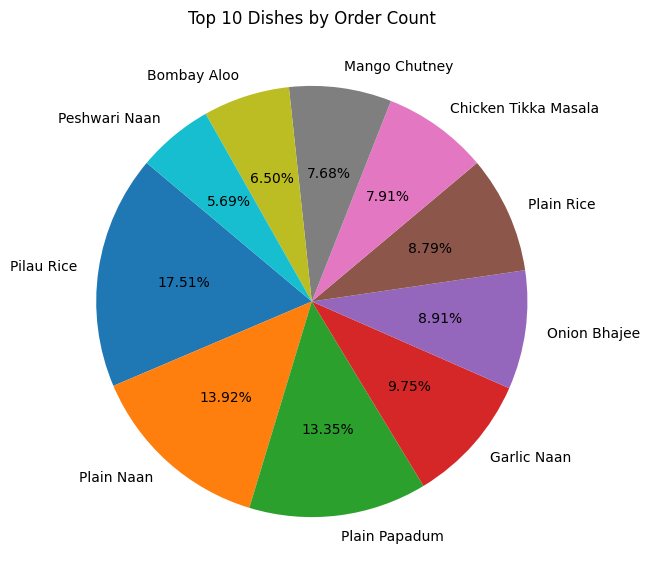

In [85]:
dishes = df["name"].value_counts()
top_10_dishes = dishes.head(10)
total_top_10 = top_10_dishes.sum()
percentages = (top_10_dishes / total_top_10) * 100
plt.figure(figsize=(10, 7))
plt.pie(percentages, labels=percentages.index, autopct="%1.2f%%", startangle=140)
plt.title("Top 10 Dishes by Order Count")
plt.show()


# Task 2
Calculate `Item Price` (Product Price * Quantity) for each Order Item in dataframe.
And Make the same Top 10 pie chart, but this time by `Item Price`. So this chart should describe not the most popular products by quantity, but which products (top 10) make the most money for restaurant. It should be also with percentage.

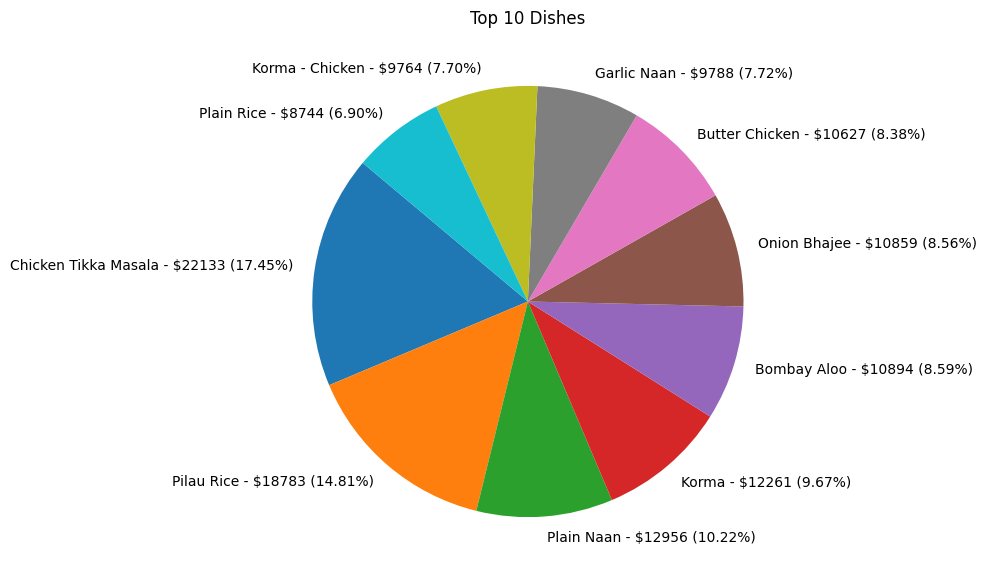

In [86]:
df["item price"] = df["quantity"] * df["price"]
revenue_per_product = df.groupby("name")["item price"].sum()
top_10_revenue_products = revenue_per_product.sort_values(ascending=False).head(10)
total_top_10_revenue = top_10_revenue_products.sum()
percentages = (top_10_revenue_products / total_top_10_revenue) * 100

plt.figure(figsize=(10, 7))
labels = ["{} - ${} ({:.2f}%)".format(label, int(round(value)), percentage) for label, value, percentage in zip(top_10_revenue_products.index, top_10_revenue_products, percentages)]
patches, texts, autotexts = plt.pie(percentages, labels=labels, autopct="", startangle=140)
plt.title("Top 10 Dishes")
plt.show()

# Task 3
Calculate `Order Hour` based on `Order Datetime`, which will tell about the specific our the order was created (from 0 to 23). Using `Order Hour` create a bar chart, which will tell the total restaurant income based on the hour order was created. So on x-axis - it will be values from 0 to 23 (hours), on y-axis - it will be the total sum of order prices, which were sold on that hour.

Example:

![bar chart](../demo/bar.png)

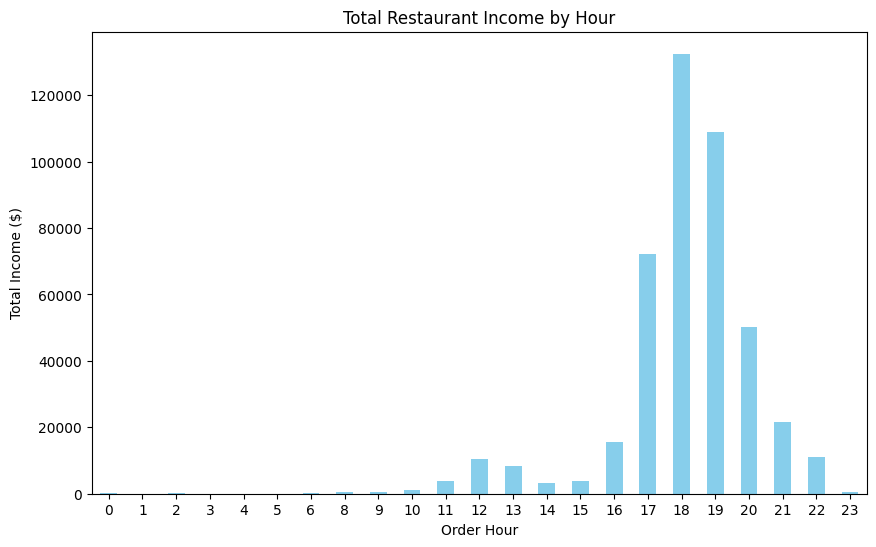

In [87]:
df["total price"] = df["quantity"] * df["price"]
df["order hour"] = pd.to_datetime(df["datetime"]).dt.hour
hourly_income = df.groupby("order hour")["total price"].sum()
plt.figure(figsize=(10, 6))
hourly_income.plot(kind="bar", color="skyblue")
plt.xlabel("Order Hour")
plt.ylabel("Total Income ($)")
plt.title("Total Restaurant Income by Hour")
plt.xticks(rotation=0)
plt.show()

# Task 4
Make similar bar chart, but right now with `Order Day Of The Week` (from Monday to Sunday), and also analyze total restaurant income by each day of the week.

C:\Users\andre\AppData\Local\Temp\ipykernel_9292\2333894675.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sales_by_day = df.groupby("order day of the week")["total price"].sum().reindex(days)


<Axes: xlabel='order day of the week'>

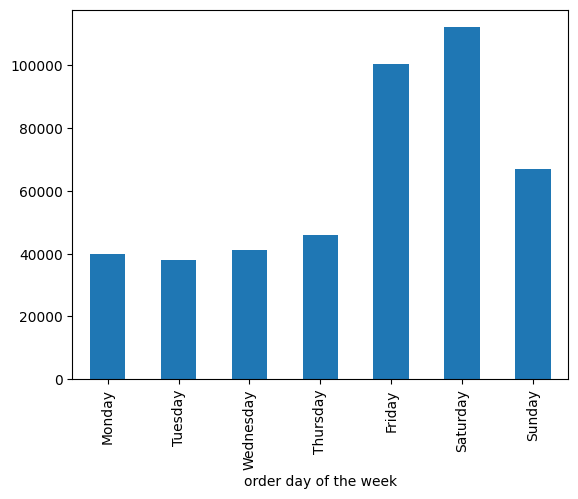

In [88]:
df["datetime"] = pd.to_datetime(df["datetime"])
df["total price"] = df["quantity"] * df["price"]
days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
df["order day of the week"] = pd.Categorical(df["datetime"].dt.strftime("%A"), categories=days, ordered=True)
df = df.sort_values("order day of the week")
sales_by_day = df.groupby("order day of the week")["total price"].sum().reindex(days)
sales_by_day.plot.bar()
